In [165]:
import requests
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import os
import folium
from dotenv import load_dotenv
load_dotenv()
from bokeh.palettes import brewer

In [166]:
import folium as fl
from sklearn import preprocessing

In [167]:
# load the token
token = os.getenv('token')
url = os.getenv('url')

In [168]:
# create function dataframe from api dataset
def get_data_frame_from_api(token,url):
    # build the header api
    headers = {'Authorization': token}
    # get request from the kobotoolbox api
    response  = requests.get(url,headers=headers)
    # convert binary content to string
    content =response.content.decode()
    # convert string to json objects
    content = json.loads(str(content))
    # create the FOKAL dataframe
    df =pd.DataFrame(content[1:])
    # rebuild the column names
    columns = [col.split("/")[-1] for col in df.columns]
    # renames the column names
    df.columns = columns
    # save the dataset to csv file
    df.to_csv('datasets/fokal_dataset1.csv')
    return df

In [169]:
def replace_all_values(df):
    df_choices = pd.read_excel('datasets/data_dict.xlsx',sheet_name='choices')
    df_survey = pd.read_excel('datasets/data_dict.xlsx',sheet_name='survey')
    map_dict = dict()
    for index,value in zip(df_choices['name'],df_choices['label::French (fr)']):
        if  'ht' not in index:
            map_dict[index] = value
    df.replace(map_dict,inplace=True)
    return df,map_dict


In [170]:
def filter_and_build_dataset(division="departement",revenu=['tranche1','tranche2','tranche3','tranche4'],site_internet="oui",subvension="oui",discipline="arts",log_transform=True,normalize=False):
    selected_feature = [division,'sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','adresse_site_internet','subventions','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
    boundary_id = dict(departement="ADM1_PCODE",commune = "ADM2_PCODE")
    boundary_name =dict(departement="ADM1_FR",commune = "ADM2_FR")
    boundary_url = dict(departement='datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp',commune="datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp")
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    col =[boundary_name[admin_level],boundary_id[admin_level],'geometry']
    boundary_data = gpd.read_file(boundary_url[admin_level])
    

In [171]:
def create_choropleth_map(dataset, boundary_data,agg_column='departement',legend="Nombre de site",log_transform=True,normalize=True,boundary_id='ADM1_PCODE',color='RdYlBu'):
    # df =  dataset.groupby(by=agg_column).size()
    # df=df.to_frame().reset_index()
    
    # if log transform is allowed
    if log_transform:
        dataset['count']= np.log(dataset['count'])
    # if normalization is allowed
    if normalize:
        values =preprocessing.normalize(dataset[['count']])
        dataset['count'] = values
    
    # convert boundary_id to upper case() for merging
   
    dataset[boundary_id] =dataset[boundary_id].str.upper()
    # display dataset
    # display(df.head())
    # merge the dataset to boundaries
    
    data_map =pd.merge(boundary_data,dataset,how='left')
     # fill na values to 0
    data_map.fillna(0,inplace=True)
    _,data_map =df_map_color(data_map,'count')
   
    # display the final dataset
    # display(data_map.head())
    # convert data to geojson for the choropleth map
    geo_data = data_map.to_json()
    # create the map
    m = folium.Map(location=[18.99997, -72.995215], zoom_start=8, control_scale=True,tiles=None)
    
    # add dataset for displaying the choropleth map
    m.choropleth(
    geo_data=geo_data,
    data=data_map,
    columns=[boundary_id, 'count'],
    key_on= f'feature.properties.{boundary_id}',
    fill_color=color, 
    fill_opacity=0.8, 
    line_opacity=1,
    legend_name=legend+ f'par {agg_column}',
    )
    return data_map,m

# display map


In [172]:
def select_choropleth_map(admin_level='departement', normalize=False, log_transform =False,boundary_id="ADM1_PCODE" ):
    boundary_data = None
    if admin_level=='departement':
        col =['ADM1_FR',boundary_id,'geometry']
        boundary_data = gpd.read_file('datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp')
    elif admin_level=='commune':
        col =['ADM2_FR',boundary_id,'geometry']
        boundary_data = gpd.read_file('datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp')
    # dataset = get_data_frame_from_api(token,url)
    boundary_data =boundary_data[col]
    boundary_data.set_geometry('geometry')
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    df_build= build_final_dataset(df=dataset,admin_level=admin_level)
    return create_choropleth_map(dataset=df_build,boundary_data=boundary_data,agg_column=admin_level,boundary_id=boundary_id,log_transform=log_transform,normalize=normalize)


 <li class="nav-item active">
          <a class="nav-link" href="#">Home <span class="sr-only">(current)</span></a>
        </li>

In [173]:
def df_map_color(data,column,palette = 'RdYlBu',range = 10):
    # creates a color palette
    palette = brewer['RdYlBu'][range]
    # reverses the color palette
    palette =palette[::-1]
    # add the color column to dataframe
    data['color'] = pd.cut(data[column], bins=range,labels=list(palette))
    # computes the palette legend
    color_map = data[data.color.notna()].groupby(['color'])[column].min().to_frame().reset_index() 
    # removes non display colunms
    color_map = color_map[color_map[column].notna()]
    display(data)
    return color_map,data

In [174]:
def  get_longitude(x):
    long_ = None
    x =str(x)
    if len(x.split(' ')) >2:
        long_ =x.split(' ')[0]
        
    return long_


In [175]:
def  get_latitude(x):
    lat_ = None
    x =str(x)
    if len(x.split(' ')) >2:
        lat_ =x.split(' ')[1]
        
    return lat_


In [199]:
def filter_data_point(group_age=['NA'],site_internet='',subvension='',discipline=['NA']):
    boundary_id = dict(departement="ADM1_PCODE",commune = "ADM2_PCODE")
    boundary_name =dict(departement="ADM1_FR",commune = "ADM2_FR")
    boundary_url = dict(departement='datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp',commune="datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp")
   
    boundary_data = None
    division = 'commune'
    boundary_data = gpd.read_file(boundary_url[division])
    boundary_data['long'] = boundary_data.geometry.centroid.x
    boundary_data['lat'] = boundary_data.geometry.centroid.y
    col =[boundary_name[division],boundary_id[division],'long','lat']
    boundary_data = boundary_data[col]
     
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    dataset = dataset.drop_duplicates(subset=['nom','prenom','age','sexe'])
    selected_features = [division,'sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','adresse_site_internet','subventions','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
    dataset = dataset[selected_features]
    dataset=dataset[~(dataset.sexe.isna() | dataset.nom.isna() | dataset.prenom.isna())]
   
    if group_age[-1] != 'NA':
        dataset = dataset[dataset.revenu_temps_normal.isin(revenu)]
        print(set(dataset.revenu_temps_normal))
    if site_internet =='oui':
        dataset = dataset[dataset.site_internet ==site_internet ]
        print("oui non")
    if subvension  =='oui':
        dataset = dataset[dataset.subventions ==subvension ]
        print("oui non")
    if discipline[-1] != 'NA':
        dataset = dataset[dataset.dis_artis_princ.isin(discipline) ]
        print(set(dataset.dis_artis_princ))

    dataset.rename(columns=boundary_id,inplace=True)
    dataset[boundary_id[division]]= dataset[boundary_id[division]].str.upper()
              
    
    
    dataset =pd.merge(boundary_data,dataset,how='inner')
    dataset.fillna(0,inplace=True)
    dataset['long'] =  dataset.apply(get_longitude)
    datastet['lat'] = dataset.apply(get_latitude)
    datastet['lat'] =  datastet['lat'].astype('float')
    datastet['long'] =  datastet['long'].astype('float')
    dataset['age_group'] = dataset.apply(age_group)
    dataset.loc[(df['long'] == 0) | (df['long'] == 1), 'long'] =  dataset.loc[(df['long'] == 0) | (df['long'] == 1), 'x']
    dataset.loc[(df['lat'] == 0) | (df['lat'] == 1), 'lat'] =  dataset.loc[(df['lat'] == 0) | (df['lat'] == 1), 'y']
    dataset = dataset.to_dict(orient='records')
    dataset = json.dumps(dataset)  
    
    return dataset



In [200]:
filter_data_point()

NameError: name 'division' is not defined

In [176]:
def filter_and_build_dataset(division="departement",revenu=['revenu_tranche1','revenu_tranche2','revenu_tranche4','revenu_tranche5','revenu_tranche6','nan'],site_internet="non",subvension="non",discipline=['musique'],log_transform=True,normalize=False):
    boundary_id = dict(departement="ADM1_PCODE",commune = "ADM2_PCODE")
    boundary_name =dict(departement="ADM1_FR",commune = "ADM2_FR")
    boundary_url = dict(departement='datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp',commune="datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp")
   
    boundary_data = None
    boundary_data = gpd.read_file(boundary_url[division])
    boundary_data['long'] = boundary_data.geometry.centroid.x
    boundary_data['lat'] = boundary_data.geometry.centroid.y
    col =[boundary_name[division],boundary_id[division],'geometry','long','lat']
    boundary_data.set_geometry('geometry')
    boundary_data = boundary_data[col]
     
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    dataset = dataset.drop_duplicates(subset=['nom','prenom','age','sexe'])
    selected_features = [division,'sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','adresse_site_internet','subventions','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
    dataset = dataset[selected_features]
    dataset=dataset[~(dataset.sexe.isna() | dataset.nom.isna() | dataset.prenom.isna())]
   
    if revenu:
        dataset = dataset[dataset.revenu_temps_normal.isin(revenu)]
    if site_internet in ('oui','non'):
        dataset = dataset[dataset.site_internet ==site_internet ]
    if subvension in ('oui','non'):
        dataset = dataset[dataset.subventions ==subvension ]
    if discipline in ('oui','non'):
        dataset = dataset[dataset.dis_artis_princ ==discipline ]
    dataset.rename(columns=boundary_id,inplace=True)
    dataset[boundary_id[division]]= dataset[boundary_id[division]].str.upper()
    
    dataset=dataset.groupby(by=boundary_id[division]).size().reset_index().rename(columns={0:'count'})
    if log_transform:
        dataset['count']= np.log(dataset['count'])
    # if normalization is allowed
    if normalize:
        values =preprocessing.normalize(dataset[['count']])
        dataset['count'] = values
        
    dataset['value'] =  dataset['count']
    
    dataset =pd.merge(boundary_data,dataset,how='left')
    dataset.fillna(0,inplace=True)
    

        
    map_color,dataset =df_map_color(dataset,'count')    
    dataset = dataset.to_json()
    map_color = map_color.to_json()
    return dataset,map_color

In [177]:
def filter_and_build_dataset(division="departement",revenu=['revenu_tranche1','revenu_tranche2','revenu_tranche4','revenu_tranche5','revenu_tranche6','nan'],site_internet="non",subvension="non",discipline=['musique'],log_transform=True,normalize=False):
    boundary_id = dict(departement="ADM1_PCODE",commune = "ADM2_PCODE")
    boundary_name =dict(departement="ADM1_FR",commune = "ADM2_FR")
    boundary_url = dict(departement='datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp',commune="datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp")
   
    boundary_data = None
    boundary_data = gpd.read_file(boundary_url[division])
    boundary_data['long'] = boundary_data.geometry.centroid.x
    boundary_data['lat'] = boundary_data.geometry.centroid.y
    col =[boundary_name[division],boundary_id[division],'geometry','long','lat']
    boundary_data.set_geometry('geometry')
    boundary_data = boundary_data[col]
     
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    dataset = dataset.drop_duplicates(subset=['nom','prenom','age','sexe'])
    selected_features = [division,'sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','adresse_site_internet','subventions','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
    dataset = dataset[selected_features]
    #dataset=dataset[~(dataset.sexe.isna() | dataset.nom.isna() | dataset.prenom.isna())]
   
    if revenu:
        dataset = dataset[dataset.revenu_temps_normal.isin(revenu)]
    if site_internet in ('oui','non'):
        dataset = dataset[dataset.site_internet ==site_internet ]
    if subvension in ('oui','non'):
        dataset = dataset[dataset.subventions ==subvension ]
    if discipline in ('oui','non'):
        dataset = dataset[dataset.dis_artis_princ ==discipline ]
    dataset.rename(columns=boundary_id,inplace=True)
    dataset[boundary_id[division]]= dataset[boundary_id[division]].str.upper()
    dataset=dataset.groupby(by=boundary_id[division]).size().reset_index().rename(columns={0:'count'})
    dataset['value'] =  dataset['count']
    if log_transform:
        dataset['count']= np.log(dataset['count'])
    # if normalization is allowed
    if normalize:
        values =preprocessing.normalize(dataset[['count']])
        dataset['count'] = values
        
   
    
    dataset =pd.merge(boundary_data,dataset,how='left')
    dataset.fillna(0,inplace=True)
    

        
    map_color,dataset =df_map_color(dataset,'count')    
    dataset = dataset.to_json()
    #map_color = map_color.to_json()
    map_color = dict(color=list(map_color['color']),values=list(map_color['count']))
    return dataset,map_color

In [197]:
def filter_and_build_dataset(revenu=['revenu_tranche1','revenu_tranche2','revenu_tranche4','revenu_tranche5','revenu_tranche6','nan'],site_internet="non",subvension="non"):
    boundary_id = dict(departement="ADM1_PCODE",commune = "ADM2_PCODE")
    boundary_name =dict(departement="ADM1_FR",commune = "ADM2_FR")
    boundary_url = dict(departement='datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp',commune="datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp")
   
    boundary_data = None
    boundary_data = gpd.read_file(boundary_url[division])
    boundary_data['long'] = boundary_data.geometry.centroid.x
    boundary_data['lat'] = boundary_data.geometry.centroid.y
    col =[boundary_name[division],boundary_id[division],'geometry','long','lat']
    boundary_data.set_geometry('geometry')
    boundary_data = boundary_data[col]
     
    dataset = pd.read_csv('datasets/fokal_dataset1.csv')
    dataset = dataset.drop_duplicates(subset=['nom','prenom','age','sexe'])
    selected_features = [division,'sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','adresse_site_internet','subventions','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
    dataset = dataset[selected_features]
    #dataset=dataset[~(dataset.sexe.isna() | dataset.nom.isna() | dataset.prenom.isna())]
   
    if revenu:
        dataset = dataset[dataset.revenu_temps_normal.isin(revenu)]
    if site_internet in ('oui','non'):
        dataset = dataset[dataset.site_internet ==site_internet ]
    if subvension in ('oui','non'):
        dataset = dataset[dataset.subventions ==subvension ]
    if discipline in ('oui','non'):
        dataset = dataset[dataset.dis_artis_princ ==discipline ]
    if 
    dataset.rename(columns=boundary_id,inplace=True)
    dataset[boundary_id[division]]= dataset[boundary_id[division]].str.upper()
   
        
   
    return dataset,map_color

In [68]:
df['count'].sum()

367.0

In [39]:
data,m=select_choropleth_map(admin_level='departement',log_transform=True,normalize=False,boundary_id='ADM1_PCODE')

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


ADM1_FR ADM1_PCODE                                           geometry  \
0   Artibonite       HT05  POLYGON ((-72.69573 19.81251, -72.69408 19.811...   
1       Centre       HT06  POLYGON ((-71.98404 19.33367, -71.98348 19.332...   
2  Grande'Anse       HT08  MULTIPOLYGON (((-73.75492 18.64331, -73.75429 ...   
3       Nippes       HT10  POLYGON ((-73.56737 18.58722, -73.56536 18.585...   
4         Nord       HT03  POLYGON ((-72.55529 19.87769, -72.55468 19.877...   
5     Nord-Est       HT04  POLYGON ((-71.96148 19.73427, -71.96014 19.733...   
6   Nord-Ouest       HT09  MULTIPOLYGON (((-72.81638 19.95254, -72.81031 ...   
7          Sud       HT07  MULTIPOLYGON (((-73.70372 18.10930, -73.70315 ...   
8      Sud-Est       HT02  POLYGON ((-72.76129 18.28151, -72.76129 18.281...   
9        Ouest       HT01  MULTIPOLYGON (((-73.20477 18.96978, -73.20427 ...   

   Femme  Homme  arts numériques  arts plastiques  audiovisuel  chant  conte  \
0    5.9   88.2              5.9              5.9          0.0    5.9    0.0   
1   40.0   60.0              0.0              0.0          0.0    0.0    0.0   
2   14.3   85.7              0.0             57.1          0.0    0.0    0.0   
3    0.0    0.0              0.0              0.0          0.0    0.0    0.0   
4    0.0  100.0              0.0              0.0         12.5    0.0    0.0   
5   33.3   66.7              0.0              0.0         33.3    0.0    0.0   
6    0.0  100.0              0.0              0.0          0.0    0.0    0.0   
7    0.0  100.0              0.0              0.0          0.0    0.0    0.0   
8   33.3   66.7              0.0              5.6         50.0    0.0    0.0   
9   27.2   69.7              3.4             16.0         10.9    6.8    0.7   

   ...  performance  photographie  théâtre  entre 240,000 et 480,000 HTG  \
0  ...          0.0          11.8     29.4                           5.9   
1  ...          0.0           0.0     40.0                           0.0   
2  ...          0.0           0.0     14.3                          14.3   
3  ...          0.0           0.0      0.0                           0.0   
4  ...          0.0           0.0     37.5                          12.5   
5  ...          0.0           0.0     66.7                          33.3   
6  ...          0.0           0.0      0.0                           0.0   
7  ...          0.0          20.0     40.0                           0.0   
8  ...          5.6           0.0     11.1                          22.2   
9  ...          2.4           5.4     18.4                          17.0   

   entre 480,000 et 720,000 HTG  entre 720,000 et 960,000 HTG  \
0                           5.9                           0.0   
1                          20.0                           0.0   
2                          14.3                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   
5                          33.3                           0.0   
6                           0.0                           0.0   
7                           0.0                           0.0   
8                           5.6                          11.1   
9                           7.5                           5.4   

   moins de 240,000 HTG  plus de 960,000 HTG     count    color  
0                  47.1                  0.0  2.833213  #fee090  
1                  60.0                 20.0  1.609438  #f46d43  
2                  57.1                  0.0  1.945910  #fdae61  
3                   0.0                  0.0  0.000000  #a50026  
4                  50.0                  0.0  2.079442  #fdae61  
5                   0.0                  0.0  1.098612  #d73027  
6                 100.0                  0.0  0.000000  #a50026  
7                  80.0                  0.0  1.609438  #f46d43  
8                  38.9                  0.0  2.890372  #e0f3f8  
9                  45.2         

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [40]:
m

In [41]:
df =pd.read_csv('datasets/fokal_dataset.csv')
build_final_dataset(df,admin_level='departement')

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


ADM1_PCODE  Femme  Homme  arts numériques  arts plastiques  audiovisuel  \
0       ht01   27.2   69.7              3.4             16.0         10.9   
1       ht02   33.3   66.7              0.0              5.6         50.0   
2       ht03    0.0  100.0              0.0              0.0         12.5   
3       ht04   33.3   66.7              0.0              0.0         33.3   
4       ht05    5.9   88.2              5.9              5.9          0.0   
5       ht06   40.0   60.0              0.0              0.0          0.0   
6       ht07    0.0  100.0              0.0              0.0          0.0   
7       ht08   14.3   85.7              0.0             57.1          0.0   
8       ht09    0.0  100.0              0.0              0.0          0.0   

   chant  conte  danse  littérature  musique  performance  photographie  \
0    6.8    0.7    6.8          9.9     17.0          2.4           5.4   
1    0.0    0.0    0.0         11.1     16.7          5.6           0.0   
2    0.0    0.0    0.0         25.0     25.0          0.0           0.0   
3    0.0    0.0    0.0          0.0      0.0          0.0           0.0   
4    5.9    0.0    0.0         11.8     29.4          0.0          11.8   
5    0.0    0.0   20.0         20.0     20.0          0.0           0.0   
6    0.0    0.0    0.0         20.0     20.0          0.0          20.0   
7    0.0    0.0    0.0         28.6      0.0          0.0           0.0   
8    0.0    0.0    0.0          0.0    100.0          0.0           0.0   

   théâtre  entre 240,000 et 480,000 HTG  entre 480,000 et 720,000 HTG  \
0     18.4                          17.0                           7.5   
1     11.1                          22.2                           5.6   
2     37.5                          12.5                           0.0   
3     66.7                          33.3                          33.3   
4     29.4                           5.9                           5.9   
5     40.0                           0.0                          20.0   
6     40.0                           0.0                           0.0   
7     14.3                          14.3                          14.3   
8      0.0                           0.0                           0.0   

   entre 720,000 et 960,000 HTG  moins de 240,000 HTG  plus de 960,000 HTG  \
0                           5.4                  45.2                  7.1   
1                          11.1                  38.9                  0.0   
2                           0.0                  50.0                  0.0   
3                           0.0                   0.0                  0.0   
4                           0.0                  47.1                  0.0   
5                           0.0                  60.0                 20.0   
6                           0.0                  80.0                  0.0   
7                           0.0                  57.1                  0.0   
8                           0.0                 100.0                  0.0   

   count  
0    294  
1     18  
2      8  
3      3  
4     17  
5      5  
6      5  
7      7  
8      1

In [42]:
df.head()

Unnamed: 0 _notes partie_groupe          nom participation_festival  \
0           0     []           non       Maitre                    non   
1           1     []           oui      SAINTIL                    oui   
2           2     []           oui  Petit Homme                    oui   
3           3     []           oui         Jean                    oui   
4           4     []           NaN          NaN                    NaN   

   _bamboo_dataset_id _tags                                          obstacle  \
0                 NaN    []                                     absence_Haïti   
1                 NaN    []  manque_formation acces_subventions absence_Haïti   
2                 NaN    []                   acces_subventions absence_Haïti   
3                 NaN    []                                     absence_Haïti   
4                 NaN    []                                               NaN   

    sexe        _xform_id_string  ...  \
0  homme  abiGcTbhyWEBA629o6dM9D  ...   
1  femme  abiGcTbhyWEBA629o6dM9D  ...   
2  femme  abiGcTbhyWEBA629o6dM9D  ...   
3  femme  abiGcTbhyWEBA629o6dM9D  ...   
4    NaN  abiGcTbhyWEBA629o6dM9D  ...   

                               adresse_site_internet     whatsapp id_twitter  \
0                                                NaN          NaN        NaN   
1                                                NaN          NaN        NaN   
2  www.collectifdesjeunesdegrosbalancepourunautre...          NaN        NaN   
3                                                NaN  50944362399       Ffmh   
4                                                NaN          NaN        NaN   

  nbre_residence_creation manque_a_gagner id_autre droits_auteur_sur_vente  \
0                     NaN             NaN      NaN                     NaN   
1                     NaN             NaN      NaN                     NaN   
2                     NaN             NaN      NaN                     NaN   
3                     NaN             NaN      NaN                     NaN   
4                     NaN             NaN      NaN                     NaN   

  societe_droit_auteur  financement_priv_etran  financement_Etat  
0                  NaN                     NaN               NaN  
1                  NaN                     NaN               NaN  
2                  NaN                     NaN               NaN  
3                  NaN                     NaN               NaN  
4                  NaN                     NaN               NaN  

[5 rows x 82 columns]

In [43]:
col =['commune','departement','sexe','prenom','nom','age','email','site_internet','dis_artis_princ','whatsapp','id_whatsapp','nationalite','email','id_facebook','id_instagram','cause_defendue','aut_act_artis','artist_gps','revenu_temps_normal']
df_final = df[df.nom.notna() & df.prenom.notna()][col]
df_final_for_group =pd.get_dummies(df_final,columns=['sexe','dis_artis_princ','revenu_temps_normal'],prefix_sep='',prefix='')
df_final_for_group.columns


Index(['commune', 'departement', 'prenom', 'nom', 'age', 'email',
       'site_internet', 'whatsapp', 'id_whatsapp', 'nationalite', 'email',
       'id_facebook', 'id_instagram', 'cause_defendue', 'aut_act_artis',
       'artist_gps', 'femme', 'homme', 'arts_numériques', 'arts_plastiques',
       'audiovisuel', 'chant', 'conte', 'danse', 'litterature', 'musique',
       'performance', 'photographie', 'theatre', 'revenu_tranche1',
       'revenu_tranche2', 'revenu_tranche4', 'revenu_tranche5',
       'revenu_tranche6'],
      dtype='object')

<AxesSubplot:>

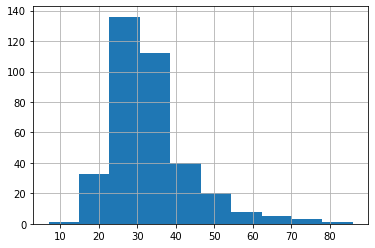

In [44]:
df_final.age.hist()

In [45]:
commune_features = ['commune', 'Femme', 'Homme', 'arts numériques', 'arts plastiques',
       'audiovisuel', 'chant', 'conte', 'danse', 'littérature', 'musique',
       'performance', 'photographie', 'théâtre',
       'entre 240,000 et 480,000 HTG', 'entre 480,000 et 720,000 HTG',
       'entre 720,000 et 960,000 HTG', 'moins de 240,000 HTG',
       'plus de 960,000 HTG']
dep_features = ['commune', 'Femme', 'Homme', 'arts numériques', 'arts plastiques',
       'audiovisuel', 'chant', 'conte', 'danse', 'littérature', 'musique',
       'performance', 'photographie', 'théâtre',
       'entre 240,000 et 480,000 HTG', 'entre 480,000 et 720,000 HTG',
       'entre 720,000 et 960,000 HTG', 'moins de 240,000 HTG',
       'plus de 960,000 HTG']
commune_group = np.round(df_final_for_group[commune_features].groupby('commune').mean()*100,1)
commune_group1 = commune_group.reset_index()
commune_group2 = df_final_for_group[commune_features].groupby('commune').size().to_frame().rename(columns={0:'count'}).reset_index()
commune_group= pd.merge(commune_group1,commune_group2,how='inner')
commune_group

KeyError: "['Femme', 'moins de 240,000 HTG', 'théâtre', 'plus de 960,000 HTG', 'entre 480,000 et 720,000 HTG', 'arts plastiques', 'littérature', 'entre 720,000 et 960,000 HTG', 'entre 240,000 et 480,000 HTG', 'arts numériques', 'Homme'] not in index"

In [46]:
df_final.shape

(370, 19)

In [6]:
# call the fuction to create the dataset
df= get_data_frame_from_api(token,url)

In [ ]:
df_map_color(df,'')

In [7]:
# split the application parametters to features
params_col = [col for col in df.columns if col.startswith('_')]
features = [col for col in df.columns if not col.startswith('_')]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 81 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   _notes                     397 non-null    object
 1   partie_groupe              373 non-null    object
 2   nom                        379 non-null    object
 3   participation_festival     368 non-null    object
 4   _bamboo_dataset_id         397 non-null    object
 5   _tags                      397 non-null    object
 6   obstacle                   372 non-null    object
 7   sexe                       368 non-null    object
 8   _xform_id_string           397 non-null    object
 9   id_whatsapp                355 non-null    object
 10  instanceID                 397 non-null    object
 11  reseau_social              378 non-null    object
 12  dis_artis_princ            376 non-null    object
 13  end                        397 non-null    object
 14  nationalit

In [13]:
df_choices = pd.read_excel('datasets/data_dict.xlsx',sheet_name='choices')
df_survey = pd.read_excel('datasets/data_dict.xlsx',sheet_name='survey')

In [14]:
df_survey.head()

type          name label::French (fr) label::Kreyol (ht)  \
0        start         start                NaN                NaN   
1          end           end                NaN                NaN   
2        today         today                NaN                NaN   
3     deviceid      deviceid                NaN                NaN   
4  begin_group  introduction       Introduction       Entwodiksyon   

  hint::French (fr) hint::Kreyol (ht) required  appearance  \
0               NaN               NaN      NaN         NaN   
1               NaN               NaN      NaN         NaN   
2               NaN               NaN      NaN         NaN   
3               NaN               NaN      NaN         NaN   
4               NaN               NaN    False  field-list   

  media::image::French (fr) media::image::Kreyol (ht) constraint  \
0                       NaN                       NaN        NaN   
1                       NaN                       NaN        NaN   
2                       NaN                       NaN        NaN   
3                       NaN                       NaN        NaN   
4                  logo.jpg                  logo.jpg        NaN   

  constraint_message choice_filter relevant calculation $given_name  
0                NaN           NaN      NaN         NaN         NaN  
1                NaN           NaN      NaN         NaN         NaN  
2                NaN           NaN      NaN         NaN         NaN  
3                NaN           NaN      NaN         NaN         NaN  
4                NaN           NaN      NaN         NaN         NaN

In [15]:
cat_columns =df_survey[df_survey.type.str.contains('select')].name.unique()

In [16]:
df_dict = df_survey[df_survey.type.str.contains('select')]

In [229]:
map_dict = dict()
for index,value in zip(df_dict['name'],df_dict['label::French (fr)']):
    if  'ht' not in index:
        map_dict[index] = value


In [230]:
df1 =df.replace(map_dict)

In [231]:
df1.head()

Unnamed: 0 _notes partie_groupe          nom participation_festival  \
0           0     []           Non       Maitre                    Non   
1           1     []           Oui      SAINTIL                    Oui   
2           2     []           Oui  Petit Homme                    Oui   
3           3     []           Oui         Jean                    Oui   
4           4     []           NaN          NaN                    NaN   

   _bamboo_dataset_id _tags                                          obstacle  \
0                 NaN    []                     absence de débouchés en Haïti   
1                 NaN    []  manque_formation acces_subventions absence_Haïti   
2                 NaN    []                   acces_subventions absence_Haïti   
3                 NaN    []                     absence de débouchés en Haïti   
4                 NaN    []                                               NaN   

    sexe        _xform_id_string  ...  \
0  Homme  abiGcTbhyWEBA629o6dM9D  ...   
1  Femme  abiGcTbhyWEBA629o6dM9D  ...   
2  Femme  abiGcTbhyWEBA629o6dM9D  ...   
3  Femme  abiGcTbhyWEBA629o6dM9D  ...   
4    NaN  abiGcTbhyWEBA629o6dM9D  ...   

                               adresse_site_internet     whatsapp id_twitter  \
0                                                NaN          NaN        NaN   
1                                                NaN          NaN        NaN   
2  www.collectifdesjeunesdegrosbalancepourunautre...          NaN        NaN   
3                                                NaN  50944362399       Ffmh   
4                                                NaN          NaN        NaN   

  nbre_residence_creation manque_a_gagner id_autre droits_auteur_sur_vente  \
0                     NaN             NaN      NaN                     NaN   
1                     NaN             NaN      NaN                     NaN   
2                     NaN             NaN      NaN                     NaN   
3                     NaN             NaN      NaN                     NaN   
4                     NaN             NaN      NaN                     NaN   

  societe_droit_auteur  financement_priv_etran  financement_Etat  
0                  NaN                     NaN               NaN  
1                  NaN                     NaN               NaN  
2                  NaN                     NaN               NaN  
3                  NaN                     NaN               NaN  
4                  NaN                     NaN               NaN  

[5 rows x 82 columns]

In [232]:
df_dep1 = df1.groupby(by='departement').size()
#df_dep1=np.log(df_dep1)
df_dep1=df_dep1.to_frame().reset_index()
df_dep1.rename(columns={0:'count','departement':'ADM1_PCODE'},inplace=True)
df_dep1.ADM1_PCODE =df_dep1.ADM1_PCODE.str.upper()
display(df_dep1)
boudaries_dep = gpd.read_file('datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp')
boudaries_dep =boudaries_dep[['ADM1_FR','ADM1_PCODE','geometry']]
boudaries_dep.set_geometry('geometry')
boudaries_dep = pd.merge(boudaries_dep,df_dep1,how='left')
boudaries_dep.fillna(0,inplace=True)
boudaries_dep.head()

ADM1_PCODE  count
0       HT01    298
1       HT02     18
2       HT03      8
3       HT04      3
4       HT05     17
5       HT06      5
6       HT07      5
7       HT08      8
8       HT09      1

ADM1_FR ADM1_PCODE                                           geometry  \
0   Artibonite       HT05  POLYGON ((-72.69573 19.81251, -72.69408 19.811...   
1       Centre       HT06  POLYGON ((-71.98404 19.33367, -71.98348 19.332...   
2  Grande'Anse       HT08  MULTIPOLYGON (((-73.75492 18.64331, -73.75429 ...   
3       Nippes       HT10  POLYGON ((-73.56737 18.58722, -73.56536 18.585...   
4         Nord       HT03  POLYGON ((-72.55529 19.87769, -72.55468 19.877...   

   count  
0   17.0  
1    5.0  
2    8.0  
3    0.0  
4    8.0

In [ ]:
def select_choropleth_map(selected_data='departement'):
    boundary_data = None
    if selected_data == 'departement':
        boundary_data = gpd.read_file('datasets/boundaries/hti_admbnda_adm1_cnigs_20181129.shp')
        boundary_data =boudaries_dep[['ADM1_FR','ADM1_PCODE','geometry']]
        boundary_data.set_geometry('geometry')
        dataset = 
        
    else 
    

In [66]:
df_dep_json = boudaries_dep.to_json()

In [67]:
df_dep_json

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"ADM1_FR": "Artibonite", "ADM1_PCODE": "HT05", "count": 18.0}, "geometry": {"type": "Polygon", "coordinates": [[[-72.69573476299996, 19.812510877000022], [-72.69408185599997, 19.811324477000028], [-72.69286283099996, 19.81048768100004], [-72.69225822299995, 19.810072650000052], [-72.69121067699996, 19.809264435000046], [-72.68947443299999, 19.808573624000076], [-72.68819132199997, 19.808222839000052], [-72.68704823999997, 19.808081625000057], [-72.68531886299996, 19.80823980100007], [-72.68367881899997, 19.808814648000066], [-72.68215886099995, 19.809002596000028], [-72.67801855199997, 19.80893074200003], [-72.68147149899994, 19.80375559600003], [-72.68038043499996, 19.801348123000025], [-72.67917855899998, 19.79737686800007], [-72.67707255799996, 19.791930749000073], [-72.67657574999998, 19.788691173000075], [-72.67620977599995, 19.786293111000077], [-72.67632292499997, 19.78441612900008], [-72.6

In [68]:
def  get_longitude(x):
    long_lat=[18.99997, -72.995215]
    x =str(x)
    if len(x.split(' ')) >2:
        long_lat = [x.split(' ')[0],x.split(' ')[1]]
        
    return [np.float(long_lat[0]), np.float(long_lat[1])]

In [69]:
import folium

In [70]:
m = folium.Map(location=[18.99997, -72.995215], zoom_start=8, control_scale=True,tiles=None)

In [25]:
m.choropleth(
    geo_data=df_dep_json,
    data=boudaries_dep,
    columns=['ADM1_PCODE', 'count'],
    key_on='feature.properties.ADM1_PCODE',
    fill_color='RdYlBu', 
    fill_opacity=0.8, 
    line_opacity=1,
    legend_name='Nombre de site par departement',
    smooth_factor=0)

# display map
m

NameError: name 'm' is not defined

In [26]:
df_dep1 = df1.groupby(by='commune').size()
df_dep1=np.log(df_dep1)
df_dep1=df_dep1.to_frame().reset_index()
df_dep1.rename(columns={0:'count','commune':'ADM2_PCODE'},inplace=True)
df_dep1.ADM2_PCODE =df_dep1.ADM2_PCODE.str.upper()
display(df_dep1)
boudaries_dep = gpd.read_file('datasets/boundaries/hti_admbnda_adm2_cnigs_20181129.shp')
boudaries_dep =boudaries_dep[['ADM2_FR','ADM2_PCODE','geometry']]
boudaries_dep.set_geometry('geometry')
boudaries_dep = pd.merge(boudaries_dep,df_dep1,how='left')
boudaries_dep.fillna(0,inplace=True)
boudaries_dep.head()

NameError: name 'df1' is not defined

In [73]:
df_dep_json = boudaries_dep.to_json()

In [74]:
m = folium.Map(location=[18.99997, -72.995215], zoom_start=8, control_scale=True,tiles=None)

In [75]:
m.choropleth(
    geo_data=df_dep_json,
    data=boudaries_dep,
    columns=['ADM2_PCODE', 'count'],
    key_on='feature.properties.ADM2_PCODE',
    fill_color='RdYlBu', 
    fill_opacity=0.8, 
    line_opacity=1,
    legend_name='Nombre de site par departement',
    smooth_factor=0)

# display map
m

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\folium\folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [27]:
m = folium.Map(location=[18.99997, -72.995215], zoom_start=9, control_scale=True)
layer1 = folium.FeatureGroup(name="Cluster Marker")
marker_cluster = MarkerCluster().add_to(layer1)

NameError: name 'MarkerCluster' is not defined

In [ ]:
logo_1 = 'https://upload.wikimedia.org/wikipedia/commons/8/8d/Logotyp_PKO_BP.svg'
logo_2 = 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Bank_Pekao_SA_Logo_%282017%29.svg'

In [ ]:
for point in df1[df1['artist_gps'].notna()]['artist_gps']:
        PKOBP = folium.Marker(point, icon=CustomIcon(logo_1, icon_size=(40, 40))).add_to(marker_cluster)

In [ ]:
m.add_child(layer1)